In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import pandas as pd
import numpy as np 
import copy
from pathlib import Path
import ast

import requests
import pickle
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from HPA_utils import pkl_save, pkl_load, load_xml
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def pkl_save(data, path):
    with open(path, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def pkl_load(path):
    with open(path, 'rb') as handle:
        data = pickle.load(handle) 
    return data

In [4]:
df = pd.read_csv('data/HPA_img_df_Michael.csv')
df

,img_file,protein_location,cell_type,gene
0,http://images.proteinatlas.org/49232/769_H3_1_...,['vesicles'],A-431,ENSG00000198919
1,http://images.proteinatlas.org/49232/769_H3_11...,['vesicles'],A-431,ENSG00000198919
2,http://images.proteinatlas.org/49232/761_H3_1_...,['vesicles'],U-2 OS,ENSG00000198919
3,http://images.proteinatlas.org/49232/761_H3_2_...,['vesicles'],U-2 OS,ENSG00000198919
4,http://images.proteinatlas.org/49232/757_H3_1_...,['vesicles'],U-251 MG,ENSG00000198919
...,...,...,...,...
86830,http://images.proteinatlas.org/60380/1082_E3_6...,['nucleoplasm'],MCF7,ENSG00000104447
86831,http://images.proteinatlas.org/60380/1103_E3_1...,['nucleoplasm'],U-2 OS,ENSG00000104447
86832,http://images.proteinatlas.org/60380/1103_E3_2...,['nucleoplasm'],U-2 OS,ENSG00000104447
86833,http://images.proteinatlas.org/60380/1252_F10_...,['nucleoplasm'],U-251 MG,ENSG00000104447


### Check for duplicate image IDs 

In [5]:
print("# of duplicate images:",len(df)- df['img_file'].unique().shape[0])
fcounts = df['img_file'].value_counts()
print("# of duplicate unique image IDs:",fcounts[fcounts > 1].keys().shape[0])

# of duplicate images: 4338
# of duplicate unique image IDs: 2460


In [6]:
dupes = pd.concat(g for _, g in df.groupby("img_file") if len(g) > 1)
res = {i: [dupes.loc[dupes['img_file'] == i]['protein_location'].unique(),
dupes.loc[dupes['img_file'] == i]['cell_type'].unique(),
dupes.loc[dupes['img_file'] == i]['gene'].unique()] for i in dupes['img_file'].unique()}
dupes_df = pd.DataFrame(res.values(), index=res.keys(), columns=['protein_location', 'cell_type', 'gene'])
dupes_df.head()

,protein_location,cell_type,gene
http://images.proteinatlas.org/10580/1610_C1_1_blue.jpg,[['vesicles']],[RH-30],"[ENSG00000081853, ENSG00000276547, ENSG0000025..."
http://images.proteinatlas.org/10580/1610_C1_2_blue.jpg,[['vesicles']],[RH-30],"[ENSG00000081853, ENSG00000276547, ENSG0000025..."
http://images.proteinatlas.org/10580/1756_B1_1_blue.jpg,"[['nucleoplasm', 'plasma membrane']]",[U-2 OS],"[ENSG00000081853, ENSG00000276547, ENSG0000025..."
http://images.proteinatlas.org/10580/1756_B1_2_blue.jpg,"[['nucleoplasm', 'plasma membrane']]",[U-2 OS],"[ENSG00000081853, ENSG00000276547, ENSG0000025..."
http://images.proteinatlas.org/10580/1758_B1_1_blue.jpg,"[['nucleoplasm', 'plasma membrane', 'cytosol']]",[SK-MEL-30],"[ENSG00000081853, ENSG00000276547, ENSG0000025..."


In [7]:
dupe_locs = {k: v[0] for k,v in res.items() if len(v[0])>1}
dupe_celltypes = {k: v[1] for k,v in res.items() if len(v[1])>1}
dupe_genes = {k: v[2] for k,v in res.items() if len(v[2])>1}

print(f"multiple protein_location assignments explain {len(dupe_locs.keys())} / {len(res.keys())} dupes.")
print(f"multiple cell_type assignments explain {len(dupe_celltypes.keys())} / {len(res.keys())} dupes.")
print(f"multiple gene assignments explain {len(dupe_genes.keys())} / {len(res.keys())} dupes.")

multiple protein_location assignments explain 0 / 2460 dupes.
multiple cell_type assignments explain 0 / 2460 dupes.
multiple gene assignments explain 2460 / 2460 dupes.


**Result:**  
It appears that all duplicate img_files are explained by multiple gene assignments. A quick look also shows that different unique image-ids have the **same** multiple ensemble IDs assigned. This likely reflects some uncertainty regarding the target of the antibody used in each of the images and/or overflow in the ensemble ID system. 

**TODO**: explore this further

In [8]:
dupe_ensmbl = pd.Series([x for i in dupe_genes.values() for x in i])
dupe_ensmbl.value_counts()

ENSG00000119048    18
ENSG00000262660    18
ENSG00000077721    18
ENSG00000230453    18
ENSG00000180071    18
                   ..
ENSG00000053371     2
ENSG00000197054     2
ENSG00000168255     2
ENSG00000256977     2
ENSG00000196589     2
Length: 1056, dtype: int64

**Remove duplicate img_files for now** 

In [9]:
df = df.drop_duplicates('img_file')

### Create onehot encoded representation of protein location labels for all img_files  

In [10]:
def parse_lbls(s): 
    s = s.replace("""['""", """'""")
    s = s.replace("""']""", """'""")
    s = ast.literal_eval(s)
    if isinstance(s, str): return [s]
    return list(s)

In [11]:
lbls = {k: parse_lbls(v) for k,v, in zip(df['img_file'].values, df['protein_location'].values)}

In [12]:
all_lbls = pd.Series([x for i in lbls.values() for x in i])
all_lbls

0            vesicles
1            vesicles
2            vesicles
3            vesicles
4            vesicles
             ...     
116759    nucleoplasm
116760    nucleoplasm
116761    nucleoplasm
116762    nucleoplasm
116763    nucleoplasm
Length: 116764, dtype: object

In [13]:
u_lbls = all_lbls.value_counts()
u_lbls

nucleoplasm                  36384
cytosol                      24836
vesicles                      9484
plasma membrane               8666
mitochondria                  6330
golgi apparatus               5119
nucleoli                      4804
nuclear speckles              2925
nuclear bodies                2697
endoplasmic reticulum         2333
nucleoli fibrillar center     1685
centrosome                    1651
nuclear membrane              1414
microtubules                  1302
cell junctions                1202
actin filaments               1058
intermediate filaments         699
nucleoli rim                   694
centriolar satellite           677
focal adhesion sites           641
cytokinetic bridge             440
cytoplasmic bodies             352
mitotic spindle                204
lipid droplets                 180
mitotic chromosome             170
aggresome                      168
peroxisomes                    146
midbody                        138
lysosomes           

In [14]:
lbl2id = {l: n for n, l in enumerate(u_lbls.keys())}
lbl2id

{'nucleoplasm': 0,
 'cytosol': 1,
 'vesicles': 2,
 'plasma membrane': 3,
 'mitochondria': 4,
 'golgi apparatus': 5,
 'nucleoli': 6,
 'nuclear speckles': 7,
 'nuclear bodies': 8,
 'endoplasmic reticulum': 9,
 'nucleoli fibrillar center': 10,
 'centrosome': 11,
 'nuclear membrane': 12,
 'microtubules': 13,
 'cell junctions': 14,
 'actin filaments': 15,
 'intermediate filaments': 16,
 'nucleoli rim': 17,
 'centriolar satellite': 18,
 'focal adhesion sites': 19,
 'cytokinetic bridge': 20,
 'cytoplasmic bodies': 21,
 'mitotic spindle': 22,
 'lipid droplets': 23,
 'mitotic chromosome': 24,
 'aggresome': 25,
 'peroxisomes': 26,
 'midbody': 27,
 'lysosomes': 28,
 'endosomes': 29,
 'midbody ring': 30,
 'rods & rings': 31,
 'microtubule ends': 32,
 'kinetochore': 33,
 'cleavage furrow': 34}

In [15]:
lbls

{'http://images.proteinatlas.org/49232/769_H3_1_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/49232/769_H3_11_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/49232/761_H3_1_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/49232/761_H3_2_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/49232/757_H3_1_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/49232/757_H3_2_blue.jpg': ['vesicles'],
 'http://images.proteinatlas.org/32138/415_D1_1_blue.jpg': ['vesicles',
  'plasma membrane',
  'cytosol'],
 'http://images.proteinatlas.org/32138/415_D1_2_blue.jpg': ['vesicles',
  'plasma membrane',
  'cytosol'],
 'http://images.proteinatlas.org/32138/411_D1_1_blue.jpg': ['cytosol'],
 'http://images.proteinatlas.org/32138/411_D1_3_blue.jpg': ['cytosol'],
 'http://images.proteinatlas.org/32138/416_D1_1_blue.jpg': ['cytosol'],
 'http://images.proteinatlas.org/32138/416_D1_2_blue.jpg': ['cytosol'],
 'http://images.proteinatlas.org/4715/1501_H1_1_blue.jpg': 

In [16]:
all_lbls.unique()

array(['vesicles', 'plasma membrane', 'cytosol', 'nucleoplasm',
       'nucleoli', 'centrosome', 'nuclear bodies', 'mitochondria',
       'nucleoli fibrillar center', 'centriolar satellite', 'aggresome',
       'midbody ring', 'cell junctions', 'microtubules',
       'cytokinetic bridge', 'midbody', 'nuclear speckles',
       'endoplasmic reticulum', 'cytoplasmic bodies', 'nucleoli rim',
       'mitotic chromosome', 'actin filaments', 'golgi apparatus',
       'focal adhesion sites', 'intermediate filaments',
       'nuclear membrane', 'peroxisomes', 'mitotic spindle',
       'lipid droplets', 'lysosomes', 'endosomes', 'cleavage furrow',
       'rods & rings', 'kinetochore', 'microtubule ends'], dtype=object)

In [17]:
def to_onehot(lbls):
    all_lbls = pd.Series([x for i in lbls.values() for x in i])
    ulbls = all_lbls.unique()
    lbl2id = {l: n for n, l in enumerate(ulbls)}
    idxs = {k: [lbl2id[i] for i in v] for k,v in lbls.items()}
    onehot = {k: np.zeros((len(ulbls))) for k in lbls.keys()}
    for k, v in idxs.items():
        onehot[k][v] = 1
    return onehot, lbl2id

In [18]:
onehot, lbl2id = to_onehot(lbls)
id2lbls = {v: k for k,v in lbl2id.items()}

onehot_df = pd.DataFrame(onehot.values(), columns=lbl2id.values(), index=onehot.keys())

onehot_df.head()

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
http://images.proteinatlas.org/49232/769_H3_1_blue.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://images.proteinatlas.org/49232/769_H3_11_blue.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://images.proteinatlas.org/49232/761_H3_1_blue.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://images.proteinatlas.org/49232/761_H3_2_blue.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
http://images.proteinatlas.org/49232/757_H3_1_blue.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
arr = np.array(list(onehot.values()))
print(arr.shape)

(82497, 35)


<BarContainer object of 35 artists>

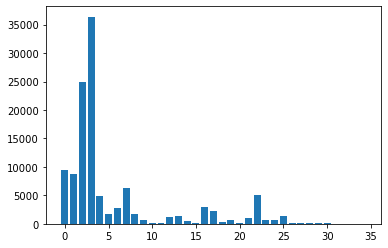

In [22]:
plt.bar(np.arange(0,arr.shape[1]),arr.sum(axis=0))

In [23]:
abs_matrix = np.dot(arr.T,arr)
cor_matrix = np.corrcoef(arr.T)

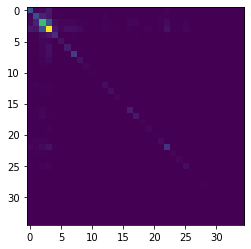

In [24]:
plt.imshow(abs_matrix)
plt.show()

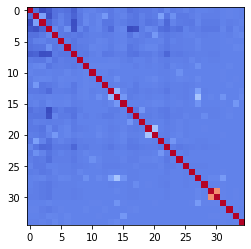

In [25]:
plt.imshow(cor_matrix, cmap='coolwarm')
plt.show()

In [26]:
np.argsort(abs_matrix.diagonal())

array([31, 33, 34, 32, 11, 30, 29, 15, 26, 10, 20, 28, 27, 18, 14, 23,  9,
       19, 24, 21, 12, 13, 25,  5,  8, 17,  6, 16,  4, 22,  7,  1,  0,  2,
        3], dtype=int64)

In [27]:
min_cor = np.unravel_index(np.argsort(cor_matrix, axis=None), cor_matrix.shape)
min_cor = [[a,b] for a,b in zip(min_cor[0][:-33], min_cor[1][:-33])][0::2]
for i in min_cor:
    print(i, cor_matrix[i[0], i[1]], abs_matrix[i[0], i[0]], abs_matrix[i[1], i[1]], abs_matrix[i[0], i[1]])

[3, 16] -0.14838984444957654 36384.0 2925.0 166.0
[0, 2] -0.14706362331634457 9484.0 24836.0 1080.0
[7, 2] -0.13886268388835388 6330.0 24836.0 507.0
[3, 7] -0.1329774703384241 36384.0 6330.0 1342.0
[17, 3] -0.13179976277743247 2333.0 36384.0 134.0
[1, 3] -0.13090161766246522 8666.0 36384.0 2178.0
[3, 0] -0.11455921307112908 36384.0 9484.0 2686.0
[0, 7] -0.0910497619556769 9484.0 6330.0 90.0
[1, 7] -0.0842099374571748 8666.0 6330.0 98.0
[3, 2] -0.07986064682554171 36384.0 24836.0 9453.0
[7, 22] -0.07301581013413283 6330.0 5119.0 6.0
[2, 22] -0.0683602577497734 24836.0 5119.0 917.0
[22, 3] -0.06402304195244089 5119.0 36384.0 1625.0
[13, 3] -0.0639028780918841 1302.0 36384.0 248.0
[3, 24] -0.05121557140588408 36384.0 699.0 116.0
[3, 21] -0.0509057098140816 36384.0 1058.0 232.0
[1, 0] -0.05022798849252736 8666.0 9484.0 591.0
[4, 0] -0.04840258481437358 4804.0 9484.0 254.0
[6, 0] -0.04745202776967327 2697.0 9484.0 88.0
[0, 16] -0.046906712421527635 9484.0 2925.0 108.0
[1, 4] -0.046701986570

[32, 30] -0.0008572132711435448 52.0 96.0 0.0
[18, 21] -0.0008500248289149402 352.0 1058.0 4.0
[12, 31] -0.0008467237915794919 1202.0 4.0 0.0
[27, 34] -0.000813174618454587 204.0 22.0 0.0
[21, 31] -0.0007936848024986897 1058.0 4.0 0.0
[11, 32] -0.0007775387114803055 79.0 52.0 0.0
[34, 28] -0.0007637331886779314 22.0 180.0 0.0
[20, 34] -0.0007421701686427838 170.0 22.0 0.0
[10, 34] -0.0007377825838058261 168.0 22.0 0.0
[14, 33] -0.0007211332073702922 440.0 8.0 0.0
[26, 13] -0.0007039764212363023 146.0 1302.0 2.0
[34, 26] -0.0006876891424800383 22.0 146.0 0.0
[34, 15] -0.000668550455608401 22.0 138.0 0.0
[18, 33] -0.0006446555691723538 352.0 8.0 0.0
[24, 31] -0.0006437076821266964 699.0 4.0 0.0
[31, 19] -0.0006413817030637361 4.0 694.0 0.0
[31, 9] -0.0006334116451756035 4.0 677.0 0.0
[31, 23] -0.0006162049778277046 4.0 641.0 0.0
[29, 34] -0.0005802587389759629 104.0 22.0 0.0
[12, 14] -0.0005706972344658041 1202.0 440.0 6.0
[30, 34] -0.0005574675004375913 96.0 22.0 0.0
[34, 11] -0.0005056

In [30]:
id2lbls

{0: 'vesicles',
 1: 'plasma membrane',
 2: 'cytosol',
 3: 'nucleoplasm',
 4: 'nucleoli',
 5: 'centrosome',
 6: 'nuclear bodies',
 7: 'mitochondria',
 8: 'nucleoli fibrillar center',
 9: 'centriolar satellite',
 10: 'aggresome',
 11: 'midbody ring',
 12: 'cell junctions',
 13: 'microtubules',
 14: 'cytokinetic bridge',
 15: 'midbody',
 16: 'nuclear speckles',
 17: 'endoplasmic reticulum',
 18: 'cytoplasmic bodies',
 19: 'nucleoli rim',
 20: 'mitotic chromosome',
 21: 'actin filaments',
 22: 'golgi apparatus',
 23: 'focal adhesion sites',
 24: 'intermediate filaments',
 25: 'nuclear membrane',
 26: 'peroxisomes',
 27: 'mitotic spindle',
 28: 'lipid droplets',
 29: 'lysosomes',
 30: 'endosomes',
 31: 'cleavage furrow',
 32: 'rods & rings',
 33: 'kinetochore',
 34: 'microtubule ends'}

In [31]:
# combs = [[1,13], [1,11], [7,11], [7,1], [5,7]]
combs = [[0,2], [7,2], [2,0], [7,1], [3,2]]
slct_u = pd.Series([x for i in combs for x in i]).unique()
slct_ds = arr[:,slct_u]
print(slct_ds.shape)

(82497, 5)


In [32]:
slct_u

array([0, 2, 7, 1, 3], dtype=int64)

#images with less than 1-6 labels: [17006, 63722, 81079, 82481, 82497, 82497]


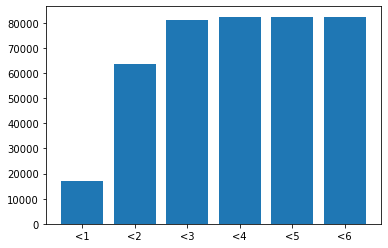

In [33]:
dist = [slct_ds[slct_ds.sum(axis=1) < i].shape[0] for i in range(1,7)]
plt.bar(['<1','<2','<3','<4', '<5', '<6'],dist)
print("#images with less than 1-6 labels:", dist)

In [36]:
slct_df = onehot_df.loc[:,slct_u]
DS = slct_df[slct_df.values.sum(axis=1) == 1]
DS.columns = [id2lbls[i] for i in DS.columns]

# merge with df to associate additional labels:
DS = pd.merge(DS, df, left_index=True, right_on='img_file', how='inner')
DS = DS[['img_file','protein_location', 'cytosol', 'vesicles', 'mitochondria','nucleoplasm', 'plasma membrane', 'cell_type', 'gene']]
DS

,img_file,protein_location,cytosol,vesicles,mitochondria,nucleoplasm,plasma membrane,cell_type,gene
0,http://images.proteinatlas.org/49232/769_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,A-431,ENSG00000198919
1,http://images.proteinatlas.org/49232/769_H3_11...,['vesicles'],0.0,1.0,0.0,0.0,0.0,A-431,ENSG00000198919
2,http://images.proteinatlas.org/49232/761_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-2 OS,ENSG00000198919
3,http://images.proteinatlas.org/49232/761_H3_2_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-2 OS,ENSG00000198919
4,http://images.proteinatlas.org/49232/757_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-251 MG,ENSG00000198919
...,...,...,...,...,...,...,...,...,...
86830,http://images.proteinatlas.org/60380/1082_E3_6...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,MCF7,ENSG00000104447
86831,http://images.proteinatlas.org/60380/1103_E3_1...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-2 OS,ENSG00000104447
86832,http://images.proteinatlas.org/60380/1103_E3_2...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-2 OS,ENSG00000104447
86833,http://images.proteinatlas.org/60380/1252_F10_...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-251 MG,ENSG00000104447


In [38]:
DS.to_csv('data/HPA_DS1.1_5xSingleLable_df.csv')

In [42]:
# Cell_types analysis

U-2 OS         14745
A-431           8634
U-251 MG        8192
MCF7            1898
HEK 293         1480
PC-3            1224
RH-30           1148
A549            1084
HeLa            1013
Hep G2           933
SH-SY5Y          928
CACO-2           896
RT4              730
SiHa             720
SK-MEL-30        568
BJ               464
HaCaT            410
HEL              316
AF22             181
REH              158
ASC TERT1        138
THP-1            126
HAP1             124
EFO-21           120
K-562             96
HUVEC TERT2       76
RPTEC TERT1       64
hTCEpi            42
LHCN-M2           42
SuSa              40
HDLM-2            36
JURKAT            34
NB-4              28
hTERT-RPE1        14
OE19              14
Name: cell_type, dtype: int64


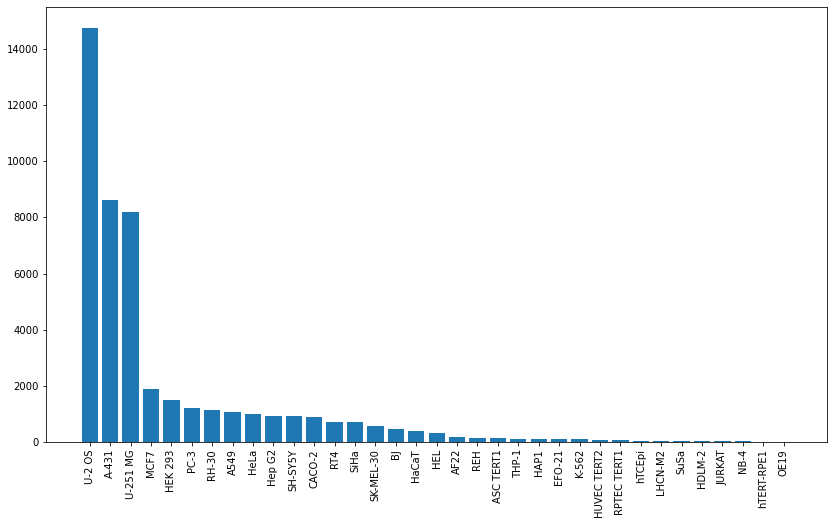

In [37]:
u_cell_types = DS['cell_type'].value_counts()
print(u_cell_types)
fig, ax = plt.subplots(1,1,figsize=(14,8))
ax.bar(u_cell_types.keys(), u_cell_types.values)
plt.xticks(rotation=90);

In [43]:
DS_3MaxCellType = DS.loc[DS['cell_type'].isin(['U-2 OS', 'A-431', 'U-251 MG'])]
DS_3MaxCellType

,img_file,protein_location,cytosol,vesicles,mitochondria,nucleoplasm,plasma membrane,cell_type,gene
0,http://images.proteinatlas.org/49232/769_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,A-431,ENSG00000198919
1,http://images.proteinatlas.org/49232/769_H3_11...,['vesicles'],0.0,1.0,0.0,0.0,0.0,A-431,ENSG00000198919
2,http://images.proteinatlas.org/49232/761_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-2 OS,ENSG00000198919
3,http://images.proteinatlas.org/49232/761_H3_2_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-2 OS,ENSG00000198919
4,http://images.proteinatlas.org/49232/757_H3_1_...,['vesicles'],0.0,1.0,0.0,0.0,0.0,U-251 MG,ENSG00000198919
...,...,...,...,...,...,...,...,...,...
86828,http://images.proteinatlas.org/31718/542_B7_2_...,"['nucleoplasm', 'nucleoli']",0.0,0.0,0.0,1.0,0.0,U-2 OS,ENSG00000096088
86831,http://images.proteinatlas.org/60380/1103_E3_1...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-2 OS,ENSG00000104447
86832,http://images.proteinatlas.org/60380/1103_E3_2...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-2 OS,ENSG00000104447
86833,http://images.proteinatlas.org/60380/1252_F10_...,['nucleoplasm'],0.0,0.0,0.0,1.0,0.0,U-251 MG,ENSG00000104447


In [ ]:
DS_3MaxCellType.to_csv('data/HPA_DS1.1_5xSingleLable_3CellTypesOnly_df.csv')

U-2 OS         26824
A-431          15284
U-251 MG       14457
MCF7            3080
HEK 293         2467
PC-3            2128
A549            1904
RH-30           1874
HeLa            1791
SH-SY5Y         1590
Hep G2          1571
CACO-2          1544
SiHa            1314
RT4             1280
SK-MEL-30       1058
BJ               816
HaCaT            766
HEL              540
AF22             281
REH              258
ASC TERT1        224
EFO-21           216
HAP1             194
THP-1            174
HUVEC TERT2      160
K-562            138
RPTEC TERT1      124
hTCEpi            88
SuSa              72
LHCN-M2           70
JURKAT            64
HDLM-2            52
NB-4              46
OE19              26
hTERT-RPE1        22
Name: cell_type, dtype: int64


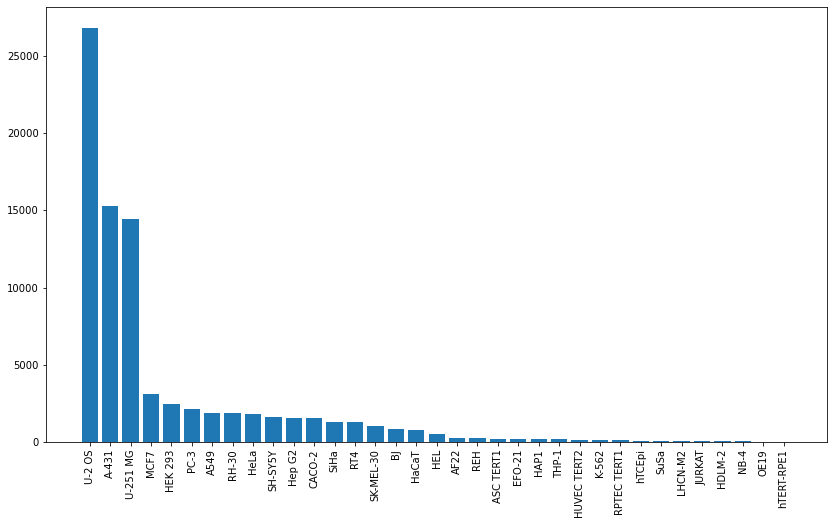

In [45]:
u_cell_types = df['cell_type'].value_counts()
print(u_cell_types)
fig, ax = plt.subplots(1,1,figsize=(14,8))
ax.bar(u_cell_types.keys(), u_cell_types.values)
plt.xticks(rotation=90);